In [1]:
import numpy as np
import pandas as pd
import h5py
import os
import time
from scipy.stats import skew, kurtosis
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import InMemoryDataset, Data
from torch.nn import Linear
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F 
from torch_geometric.nn import TopKPooling, global_mean_pool, ChebConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader
import torch.backends.cudnn as cudnn
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

device = 'cuda:0'

In [2]:
# class EEGDataset(InMemoryDataset):
#     def __init__(self, root, eeg, tasks, transform=None, pre_transform=None):
#         self.eeg = eeg
#         self.y = tasks
#         super(EEGDataset, self).__init__(root, transform, pre_transform)
#         self.data, self.slices = torch.load(self.processed_paths[0])
        
#     @property
#     def raw_file_names(self):
#         return []
    
#     @property
#     def processed_file_names(self):
#         return ['data.pt']
    
#     def download(self):
#         pass
    
#     def process(self):
        
#         data_list = []
        
#         for sample_ind in range(self.eeg.shape[0]):
#             sample = self.eeg[sample_ind]
#             task = self.y[sample_ind]
#             feature_matrix, adjacency_matrix = getFeaturesAdjacency(sample)
#             # get edge index
#             valid_edges = np.where(adjacency_matrix > 0)
#             edge_index = np.vstack((valid_edges[0], valid_edges[1]))
#             # get edge attributes
#             nonzero_ind = np.where(adjacency_matrix.ravel())[0]
#             edge_attr = adjacency_matrix.ravel()[nonzero_ind][..., np.newaxis]
            
#             data = Data(x=torch.FloatTensor(feature_matrix),
#                         edge_index=torch.tensor(edge_index, dtype=torch.long),
#                         edge_attr=torch.FloatTensor(edge_attr),
#                         y=torch.tensor(task-1, dtype=torch.long))
#             data_list.append(data)
        
#         self.data, self.slices = self.collate(data_list)
#         torch.save((self.data, self.slices), self.processed_paths[0])

In [3]:
class EEGDataset(InMemoryDataset):
    def __init__(self, root, eeg=None, tasks=None, transform=None, pre_transform=None):
        self.eeg = eeg
        self.y = tasks
        super(EEGDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        return []
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def download(self):
        pass
    
    def process(self):
        
        data_list = []
        for i in range(len(self.eeg.edge_index)):
            data = Data(x=torch.FloatTensor(self.eeg.feature_matrix[i]),
                    edge_index=torch.tensor(self.eeg.edge_index[i], dtype=torch.long),
                    edge_attr=torch.FloatTensor(self.eeg.edge_attr[i]),
                    y=torch.tensor(self.y[i]-1, dtype=torch.long))    # save tasks
            data_list.append(data)
        
        self.data, self.slices = self.collate(data_list)
        torch.save((self.data, self.slices), self.processed_paths[0])

In [4]:
class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.conv1 = ChebConv(tr_dataset.num_features, 32, K=3)
        self.conv2 = ChebConv(32, 64, K=4)
        self.conv3 = ChebConv(64, 128, K=5)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.bn3 = torch.nn.BatchNorm1d(128)

        # Output layer
        self.dense = Linear(128*2, tr_dataset.num_classes)

    def forward(self, x, edge_index, batch_index, edge_weight):

        # Conv layers
        hidden = self.conv1(x, edge_index, edge_weight)
        hidden = self.bn1(hidden)
        hidden = F.relu(hidden)
        
        hidden = self.conv2(hidden, edge_index, edge_weight)
        hidden = self.bn2(hidden)
        hidden = F.relu(hidden)
        
        hidden = self.conv3(hidden, edge_index, edge_weight)
        hidden = self.bn3(hidden)
        hidden = F.relu(hidden)
        
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        
        # Apply a final (linear) classifier.
        hidden = self.dense(hidden)

        return F.log_softmax(hidden, dim=1)

In [5]:
def train():
    model.train()
    running_loss = 0
    accuracy = 0
    for batch in trainloader:
        # Use GPU
        batch.cuda() 
        # Reset gradients
        optimizer.zero_grad()
        # Passing the node features and the connection info
        pred = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.flatten()) 
        # Calculating the loss and gradients
        loss = criterion(pred, batch.y)
        loss.backward()
        running_loss += loss.item()
        # Update using the gradients
        optimizer.step()
        accuracy += (torch.argmax(pred, dim=1) == batch.y).float().mean()
    return running_loss/len(trainloader), accuracy/len(trainloader)

In [6]:
def test(epoch, testloader=None, training=True):
    global best_acc, best_epoch, epochs_no_improve, patience,\
           early_stop, test_losses, batch_size, bestModel
    model.eval()
    test_loss = 0
    accuracy = 0
    y_preds = []
    y_true = []
    
    with torch.no_grad():
        for batch in testloader:
            # Use GPU
            batch.cuda()
            
            pred = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.flatten())
            loss = criterion(pred, batch.y)
            test_loss += loss.item()          
            accuracy += (torch.argmax(pred, dim=1) == batch.y).float().mean()
            
            if not training:
                y_preds.append(torch.argmax(pred, dim=1).cpu())
                y_true.append(batch.y.cpu())

    clean_acc = 100.*accuracy/len(testloader)
    if epoch == 1:
        best_acc = clean_acc
    if (clean_acc > best_acc):
        print('Saving..')
        torch.save(model.state_dict(), bestModel)
        epochs_no_improve = 0
        best_acc = clean_acc
        best_epoch = epoch
    else:
        epochs_no_improve += 1
    
    if epoch > 5 and epochs_no_improve == patience:
        print('Early stopping!')
        early_stop = True
    
    if not training:
        return test_loss/len(testloader), accuracy/len(testloader), y_preds, y_true
    else:
        return test_loss/len(testloader), accuracy/len(testloader)

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=36)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=30)
    plt.yticks(tick_marks, classes, fontsize=30)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=28)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

In [8]:
savePath = '/scratch/qh503/deepLearningProject/data_GCN/timeFreq25_tr1800val360ts_normExtractNorm_normTimeFreq/'
bestModel = './models/baseline_tr1800-val360ts_normExtractNorm_normTimeFreq.pth'

## Extract features for each sample

In [9]:
%%time
tr_dataset = EEGDataset(root=os.path.join(savePath, 'train'))
val_dataset = EEGDataset(root=os.path.join(savePath, 'valid'))
ts_dataset = EEGDataset(root=os.path.join(savePath, 'test'))
tr_dataset

CPU times: user 21.1 ms, sys: 172 ms, total: 193 ms
Wall time: 634 ms


EEGDataset(1800)

In [10]:
# Wrap data in a data loader
batch_size = 32
num_workers = 2
trainloader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
testloader = DataLoader(ts_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [11]:
model = GCN().cuda()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))
cudnn.benchmark = True

GCN(
  (conv1): ChebConv(25, 32, K=3, normalization=sym)
  (conv2): ChebConv(32, 64, K=4, normalization=sym)
  (conv3): ChebConv(64, 128, K=5, normalization=sym)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense): Linear(in_features=256, out_features=4, bias=True)
)
Number of parameters:  53252


In [12]:
lr = 4e-4
# early stopping variables
epochs_no_improve = 0
patience = 80
early_stop = False
best_acc = 0
best_epoch = 0

# cross entropy
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = MultiStepLR(optimizer, milestones=[60, 110], gamma=0.1)

In [13]:
%%time
print("Starting training...")
epochs = 301
train_losses, train_accs = [], []
valid_losses, valid_accs = [], []
for epoch in range(1, epochs):
    start = time.time()
    train_loss, train_acc = train()
    valid_loss, valid_acc = test(epoch, validloader)
    if epoch % 10 == 0:
        print('\nepoch#: {} | train loss: {:.3f} | val loss: {:.3f} | train acc: {:.3f} | val acc: {:.3f}'\
              .format(epoch, train_loss, valid_loss, train_acc*100, valid_acc*100))
        print('Best Acc: {:.3f} | Best Epoch: {} | epochs_no_improve: {}'\
              .format(best_acc, best_epoch, epochs_no_improve))
        print(f"Device = {device}; Time per iter: {(time.time() - start):.3f} seconds")
    
    if early_stop:
        print('Stopped')
        break
    scheduler.step(epoch)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

Starting training...
Saving..
Saving..
Saving..
Saving..
Saving..
Saving..

epoch#: 10 | train loss: 0.909 | val loss: 1.101 | train acc: 67.270 | val acc: 54.688
Best Acc: 54.688 | Best Epoch: 10 | epochs_no_improve: 0
Device = cuda:0; Time per iter: 1.271 seconds
Saving..
Saving..

epoch#: 20 | train loss: 0.576 | val loss: 1.034 | train acc: 85.471 | val acc: 56.771
Best Acc: 56.771 | Best Epoch: 14 | epochs_no_improve: 6
Device = cuda:0; Time per iter: 1.317 seconds
Saving..
Saving..
Saving..
Saving..

epoch#: 30 | train loss: 0.340 | val loss: 1.023 | train acc: 95.011 | val acc: 57.292
Best Acc: 58.594 | Best Epoch: 28 | epochs_no_improve: 2
Device = cuda:0; Time per iter: 1.265 seconds
Saving..
Saving..

epoch#: 40 | train loss: 0.195 | val loss: 1.075 | train acc: 98.629 | val acc: 57.812
Best Acc: 60.417 | Best Epoch: 39 | epochs_no_improve: 1
Device = cuda:0; Time per iter: 1.242 seconds
Saving..

epoch#: 50 | train loss: 0.118 | val loss: 1.108 | train acc: 99.232 | val acc:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


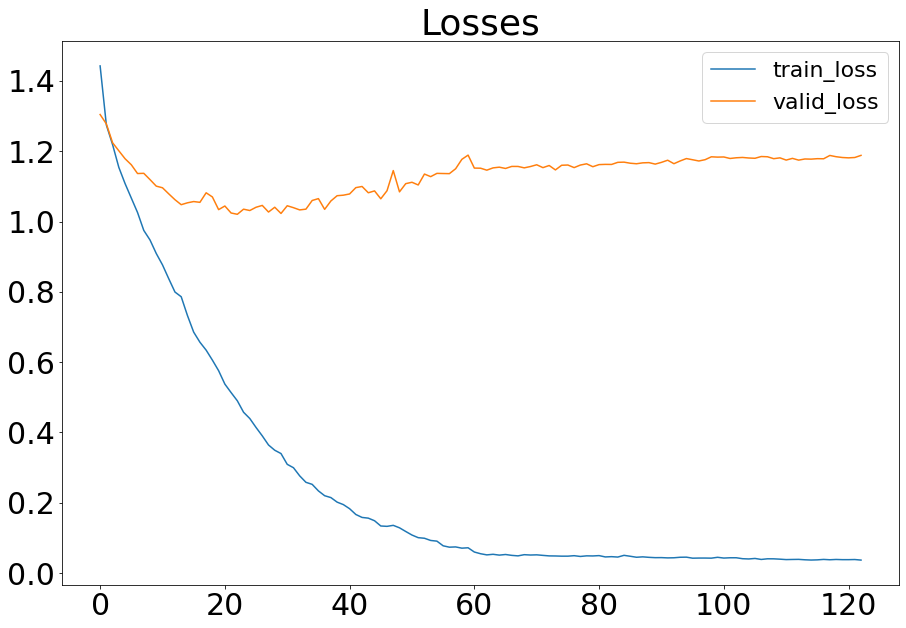

In [14]:
fig = plt.figure(figsize=(15,10))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Losses', fontsize=36)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(['train_loss', 'valid_loss'], prop={'size': 22})
plt.savefig('baseline_tr1800-val360ts_normExtractNorm_losses.eps', format='eps', dpi=100)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


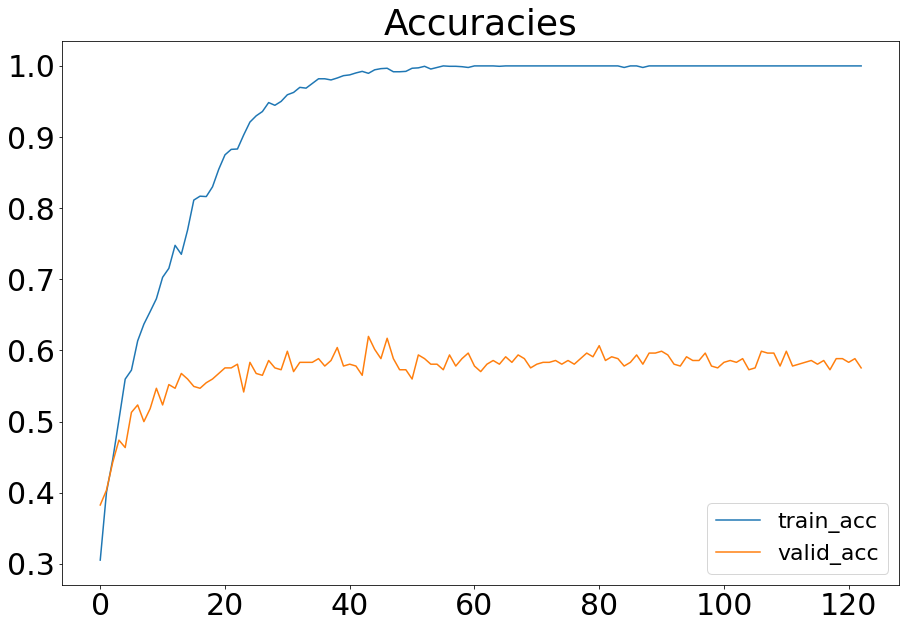

In [15]:
fig = plt.figure(figsize=(15,10))
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Accuracies', fontsize=36)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(['train_acc', 'valid_acc'], prop={'size': 22})
plt.savefig('baseline_tr1800-val360ts_normExtractNorm_accs.eps', format='eps', dpi=100)

In [16]:
# load in best model
best_model_path = bestModel
# define a new GCN
model = GCN()
# load state_dict
state_dict = torch.load(best_model_path)
# load the state dict into the new NN
model.load_state_dict(state_dict)
# send new NN to gpu
# turn on evaluation mode
model = model.cuda()
model.eval()
cudnn.benchmark = True

In [17]:
test_loss, test_acc, y_preds, y_true = test(1, testloader, training=False)
print('test loss: {:.3f} | test acc: {:.3f}'.format(test_loss, test_acc*100))

test loss: 1.178 | test acc: 56.771


In [18]:
y_pred = [x for y_pred in y_preds for x in y_pred]
y_test = [x for y_test in y_true for x in y_test]

In [19]:
target_names = ['open one hand', 'imagine open one hand', 'open both hands/feet', 'imagine open both hands/feet']
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

                              precision    recall  f1-score   support

               open one hand     0.6486    0.5333    0.5854        90
       imagine open one hand     0.4720    0.6556    0.5488        90
        open both hands/feet     0.6154    0.5333    0.5714        90
imagine open both hands/feet     0.5783    0.5333    0.5549        90

                    accuracy                         0.5639       360
                   macro avg     0.5786    0.5639    0.5651       360
                weighted avg     0.5786    0.5639    0.5651       360



In [20]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[48, 21, 13,  8],
       [ 6, 59, 10, 15],
       [12, 18, 48, 12],
       [ 8, 27,  7, 48]])

Normalized confusion matrix
[[0.53333333 0.23333333 0.14444444 0.08888889]
 [0.06666667 0.65555556 0.11111111 0.16666667]
 [0.13333333 0.2        0.53333333 0.13333333]
 [0.08888889 0.3        0.07777778 0.53333333]]


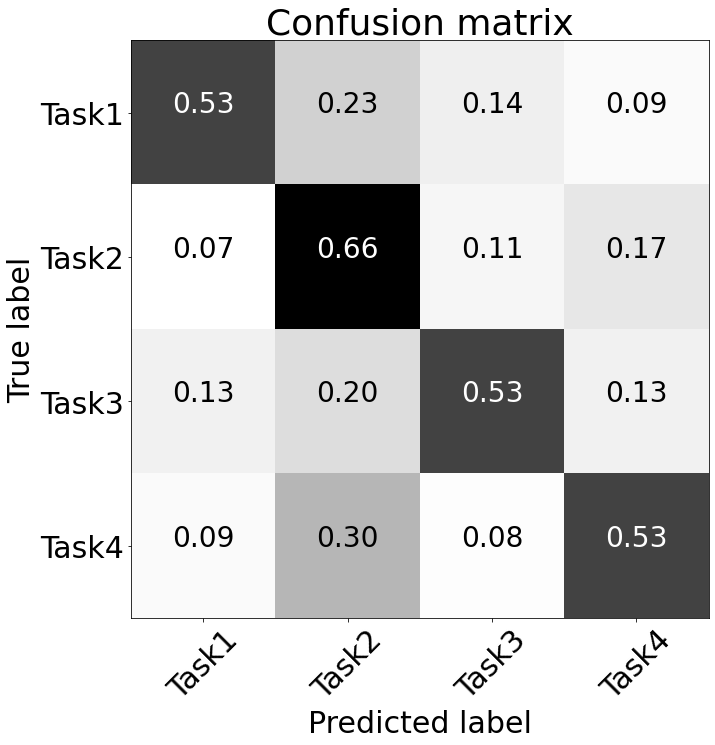

In [21]:
plot_confusion_matrix(cm, ['Task1', 'Task2', 'Task3', 'Task4'], normalize=True, title='Confusion matrix', cmap=plt.cm.Greys)
plt.savefig('baseline_tr1800-val360ts_normExtractNorm_time_cm.eps', format='eps', dpi=100)